In [1]:
import lime
from lime import lime_tabular
import numpy as np
import pandas as pd
import tensorflow.keras as keras
import matplotlib.pyplot as pyplot
from sklearn.preprocessing import normalize
import seaborn as sns
import json
import math
import time
import ast
from IPython.display import clear_output
import os

In [2]:
# EDIT HERE FOR OTHER COURSES
data_path = '/Volumes/MOOC/flipped/apr21-feature-mooc-flipped/'
week_type = 'eq_week'
feature_types = ['akpinar_et_al', 'boroujeni_et_al', 
                 'chen_cui', 'he_et_al', 'lalle_conati','lemay_doleck', 
                 'marras_et_al', 'mbouzao_et_al', 'mubarak_et_al', 'wan_et_al']
course = 'epfl_algebrelineaire'
marras_et_al_id = feature_types.index('marras_et_al')
akpinar_et_al_id = feature_types.index('akpinar_et_al')
remove_obvious = True

# Loading the features and their names

In [3]:
# function that replaces NaNs with the minimum of that feature over all weeks
def fillNaN(feature):
    shape = feature.shape
    feature_min = np.nanmin(
        feature.reshape(-1, shape[2]), axis=0
    )  # min of that feature over all weeks
    feature = feature.reshape(-1, shape[2])
    inds = np.where(np.isnan(feature))
    feature[inds] = np.take(feature_min.reshape(-1), inds[1])
    feature = feature.reshape(shape)
    return feature

In [4]:
# Loading the features
feature_list = {}

feature_type_list = []
for feature_type in feature_types:

    filepath = data_path + week_type + '-' + feature_type + '-' + course
    feature_current = np.load(filepath+'/feature_values.npz')['feature_values']
    print(feature_current.shape)
    feature_norm = feature_current.reshape(-1,feature_current.shape[2] )
    print(feature_norm.shape)
    feature_type_list.append(pd.DataFrame(feature_norm))
feature_list[course] = feature_type_list

print('course: ', course)
print('week_type: ', week_type)
print('feature_type: ', feature_types)

(214, 14, 347)
(2996, 347)
(214, 14, 3)
(2996, 3)
(214, 14, 13)
(2996, 13)
(214, 14, 3)
(2996, 3)
(214, 14, 22)
(2996, 22)
(214, 14, 10)
(2996, 10)
(214, 14, 12)
(2996, 12)
(214, 14, 3)
(2996, 3)
(214, 14, 13)
(2996, 13)
(214, 14, 14)
(2996, 14)
course:  epfl_algebrelineaire
week_type:  eq_week
feature_type:  ['akpinar_et_al', 'boroujeni_et_al', 'chen_cui', 'he_et_al', 'lalle_conati', 'lemay_doleck', 'marras_et_al', 'mbouzao_et_al', 'mubarak_et_al', 'wan_et_al']


In [5]:
# Loading feature names
feature_names= dict()

for feature_type in feature_types:
    
    filepath = data_path + week_type + '-' + feature_type + '-' + course + '/settings.txt'
    file = open(filepath, "r")
    contents = file.read()
    dictionary = ast.literal_eval(contents)
    file.close()
    
    feature_type_name = dictionary['feature_names']
    if feature_type == 'akpinar_et_al':
        akp_mask = np.where(np.isin(feature_type_name, 
                 ["TotalClicks", "NumberSessions", "Time-video-sum", "Time-problem-sum",
                  'problem.check-problem.check-problem.check', 
                  'problem.check-problem.check-video.load', 
                  'video.play-video.play-video.play',
                  'video.play-video.pause-video.load',
                  'video.play-problem.check-problem.check',
                  'video.play-video.stop-video.play',
                  'video.pause-video.speedchange-video.play',
                  'video.stop-video.play-video.seek',
                  'video.stop-problem.check-video.load']))
        print(akp_mask)
        feature_type_name = list(np.array(feature_type_name)[akp_mask[0]])
        feature_list[course][akpinar_et_al_id] = feature_list[course][akpinar_et_al_id][akp_mask[0]]
        
    feature_names[feature_type] = feature_type_name
    print(feature_type, len(feature_type_name))

if remove_obvious: 
    # drop 'student shape', 'competency strength', 'competency alignment' in marras at al
    
    mask = np.where(np.isin(feature_names['marras_et_al'], 
                 ['StudentShape', 'CompetencyStrength', 'CompetencyAlignment']))
    
    new_marras = np.delete(np.array(feature_names['marras_et_al']), mask[0])
    feature_names['marras_et_al'] = new_marras
    
    new_features = feature_list[course][marras_et_al_id].drop(mask[0], axis=1)
    feature_list[course][marras_et_al_id] = new_features


(array([  0,   1,   2,   3,  41, 103, 118, 132, 150, 217, 243, 341, 346]),)
akpinar_et_al 13
boroujeni_et_al 9
chen_cui 13
he_et_al 3
lalle_conati 22
lemay_doleck 10
marras_et_al 12
mbouzao_et_al 3
mubarak_et_al 14
wan_et_al 14


In [6]:
# reformat feature names
# ex: time_sessions_<function sum at 0x7f3bd02cc9d0> -> time_sessions_sum
def clean_name(feature):
    id = feature.find('<')
    if id==-1:
        return feature
    fct = feature[id+9:id+14].strip()
    return feature[0:id]+fct


for k in feature_names.keys():
    cleaned = [clean_name(x) for x in feature_names[k]]
    feature_names[k] = cleaned


In [7]:
def load_labels(course):
    feature_type = "boroujeni_et_al"
    filepath = data_path + week_type + '-' + feature_type + '-' + course + '/feature_labels.csv'
    labels = pd.read_csv(filepath)['label-pass-fail']
    labels[labels.shape[0]] = 1
    return labels.values

def load_features(course):
    feature_list = []
    selected_features = []
    total_features = set()
    num_weeks = 0
    num_features = 0
    for i,feature_type in enumerate(feature_types):
        filepath = data_path + week_type + '-' + feature_type + '-' + course 
        feature_current = np.load(filepath+'/feature_values.npz')['feature_values']
        
        shape = feature_current.shape
#         print(shape)

        if remove_obvious and feature_type=='marras_et_al':
            feature_current = np.delete(feature_current, mask[0], axis=2)
        
        if feature_type=='akpinar_et_al':
            akp_mask_dl = np.delete(list(range(shape[2])), akp_mask[0])
            feature_current = np.delete(feature_current, akp_mask_dl, axis=2)
        
        shape = feature_current.shape
        print(shape)
        if i==0:
            num_weeks = shape[1]
        
        
        selected = np.arange(shape[2])
        # drop existed features
        exist_mask = []
        for i, name in enumerate(feature_names[feature_type]):
            if name in total_features:
                exist_mask.append(i)
            else:
                total_features.add(name)
        feature_current = np.delete(feature_current, exist_mask, axis=2)
        selected = np.delete(selected, exist_mask)
        
        nonNaN = (shape[0]*shape[1] - np.isnan(feature_current.reshape(-1,feature_current.shape[2])).sum(axis=0) > 0)
        feature_current = feature_current[:,:,nonNaN]
        selected = selected[nonNaN]
        feature_current = fillNaN(feature_current)
        nonZero = (abs(feature_current.reshape(-1,feature_current.shape[2])).sum(axis=0)>0)
        selected = selected[nonZero]
        feature_current = feature_current[:,:,nonZero]
#         print(len(feature_names[feature_type]), selected)
        selected_features.append(np.array(feature_names[feature_type])[[selected]])
        num_features += len(np.array(feature_names[feature_type])[[selected]])


        ##### Normalization with min-max. Added the artifical 1.001 max row for solving the same min max problem
        ##### for features with max=0 I added 1 instead of 1.001 of maximum

        features_min = feature_current.min(axis=0).reshape(-1)
        features_max = feature_current.max(axis=0)
        features_max = np.where(features_max==0,np.ones(features_max.shape),features_max)
        max_instance = 1.001*features_max
        feature_current = np.vstack([feature_current,max_instance.reshape((1,)+max_instance.shape)])
        features_max = features_max.reshape(-1)
        feature_norm = (feature_current.reshape(shape[0]+1,-1)-features_min)/(1.001*features_max-features_min)
        feature_current = feature_norm.reshape(-1,feature_current.shape[1],feature_current.shape[2] )

        feature_list.append(feature_current)
        
    features = np.concatenate(feature_list, axis=2)
    features_min = features.min(axis=0).reshape(-1)
    features_max = features.max(axis=0)
    features = features.reshape(features.shape[0],-1)
    features = pd.DataFrame(features)
    
    SHAPE = features.shape
    # print(np.isnan(features[0,0,-1]))
    print('features shape:', features.shape)
    print('course: ', course)
    print('week_type: ', week_type)
    print('feature_type: ', feature_types)
    print(selected_features)
    return features, features_min, features_max, selected_features, num_weeks, num_features


In [8]:
y = load_labels(course)

In [9]:
features, features_min, features_max, selected_features, num_weeks, num_features = load_features(course)

(214, 14, 13)
(214, 14, 3)
(214, 14, 13)
(214, 14, 3)
(214, 14, 22)
(214, 14, 10)
(214, 14, 9)
(214, 14, 3)


/var/folders/16/kn9v95ss6kx75q2kjs2mn9jm0000gn/T/ipykernel_6985/847209558.py:53: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  selected_features.append(np.array(feature_names[feature_type])[[selected]])
/var/folders/16/kn9v95ss6kx75q2kjs2mn9jm0000gn/T/ipykernel_6985/847209558.py:54: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  num_features += len(np.array(feature_names[feature_type])[[selected]])


(214, 14, 13)
(214, 14, 14)
features shape: (215, 1148)
course:  epfl_algebrelineaire
week_type:  eq_week
feature_type:  ['akpinar_et_al', 'boroujeni_et_al', 'chen_cui', 'he_et_al', 'lalle_conati', 'lemay_doleck', 'marras_et_al', 'mbouzao_et_al', 'mubarak_et_al', 'wan_et_al']
[array(['TotalClicks', 'NumberSessions', 'Time-video-sum',
       'Time-problem-sum', 'video.pause-video.speedchange-video.play',
       'video.play-video.pause-video.load',
       'video.play-video.play-video.play',
       'video.play-video.stop-video.play',
       'video.play-problem.check-problem.check',
       'video.stop-video.play-video.seek',
       'video.stop-problem.check-video.load',
       'problem.check-problem.check-video.load',
       'problem.check-problem.check-problem.check'], dtype='<U41'), array(['RegPeakTime-m1', 'RegPeriodicity-m1', 'DelayLecture'],
      dtype='<U17'), array(['TimeSessions-sum', 'TimeSessions-mean', 'TimeBetweenSessions-std',
       'TimeSessions-std', 'TotalClicks-weekday',

In [10]:
# calculate the number of features
n_features = sum([len(x) for x in selected_features])

In [11]:
n_features

82

In [12]:
feature_dict = dict()
for i, feature_type in enumerate(feature_types):
    feature_dict[feature_type] = list(selected_features[i])
    
selected_features = feature_dict
# print(selected_features)
# file = 'selected_features/' + course + '_after.json'
# with open(file, 'w') as f: 
#     json.dump(selected_features, f)

In [13]:
num_feature_type = []
for feature_type in feature_types:
    num_feature_type.append(len(selected_features[feature_type]))
print(num_feature_type)

[13, 3, 7, 3, 17, 10, 9, 1, 7, 12]


In [14]:
# Loading feature names and transforming them to 2D format.
feature_names = []
final_features = []
for i,feature_type in enumerate(feature_types):
    [final_features.append(x) for x in selected_features[feature_type]]
for i in np.arange(num_weeks):
    feature_type_name_with_weeks = [(x+'_InWeek'+str(i+1)) for x in final_features]
    feature_names.append(feature_type_name_with_weeks)
feature_names = np.concatenate(feature_names, axis=0)
feature_names = feature_names.reshape(-1)
# print(feature_names)
features.columns = feature_names

In [15]:
# This block loads number of features in each feature set.
num_feature_type = []
for i,feature_type in enumerate(feature_types):
    num_feature_type.append(len(selected_features[feature_type]))
print(num_feature_type)


[13, 3, 7, 3, 17, 10, 9, 1, 7, 12]


# Making a predict_proba

In [16]:
# This module transforms our data to the 2D format biLSTM was trained with.
def transform_x(x, num_feature_type, num_weeks, features_min, features_max):
    x = np.array(x)
    num_feature_type = np.array(num_feature_type)
    num_features = num_feature_type.sum()
    x = x.reshape((-1, num_weeks, num_features))
    shape = x.shape
    features_max = np.where(
        features_max == 0, np.ones(features_max.shape), features_max
    )
    max_instance = 1.001 * features_max
    feature_current = np.vstack([x, max_instance.reshape((1,) + max_instance.shape)])
    features_max = features_max.reshape(-1)
    feature_norm = (feature_current.reshape(shape[0] + 1, -1) - features_min) / (
        1.001 * features_max - features_min
    )
    x = feature_norm[: feature_norm.shape[0] - 1, :]
    return x

In [17]:
print(features.shape)
# EDIT HERE FOR OTHER MODELS
model_path = '../models/'
model_name = model_path + "lstm_bi_"+course
loaded_model = keras.models.load_model(model_name)


(215, 1148)


2022-08-10 09:15:09.471093: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-10 09:15:10.684331: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-08-10 09:15:12.232994: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-08-10 09:15:12.716794: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes m

In [18]:
# This lambda returns a (NUM OF INSTANCES,2) array of prob of pass in first column and prob of fail in another column
# This lambda returns a (NUM OF INSTANCES,2) array of prob of pass in first column and prob of fail in another column
predict_fn = lambda x: np.array(
    [[1-loaded_model.predict(transform_x(x,num_feature_type,num_weeks,features_min,features_max))],
     [loaded_model.predict(transform_x(x,num_feature_type,num_weeks,features_min,features_max))]]).reshape(2,-1).T


## Creating a LIME tabular explainer for the Loaded features 

In [29]:
# This module makes tabular lime explainer with instance numbers given to it.
def instance_explainer(instance_numbers,features,feature_names,class_names,predict_fn, 
                       num_features=10,mode='classification',
                       discretize_continuous=True, num_samples=5000, 
                       distance_metric='euclidean', model_regressor=None, sampling_method='gaussian'):
    explainers=[]
    features=np.array(features)
    feature_names=np.array(feature_names).reshape(-1)
    explainer = lime_tabular.LimeTabularExplainer(
      training_data=features,
      feature_names=feature_names,
      class_names=class_names,
      mode=mode,
      discretize_continuous=discretize_continuous
    )
    for i in instance_numbers:
        exp = explainer.explain_instance(features[i], predict_fn, num_features=num_features)
        explainers.append(exp)
    return explainers


In [30]:
def show_all_in_notebook(explainers,instances,real_labels,features,num_weeks,num_feature_type,group):
    for i,exp in enumerate(explainers):
        print("For instance number {i:d} the explanation is as follows:".format(i=instances[i]))
        s = 'fail' if real_labels[instances[i]] else 'pass'
        print("The real label for this instance is {}".format(s))
        p = predict_fn(features[instances[i],:])
        s = 'fail' if p[0,1]>0.5 else 'pass'
        print('The model predicted label for this instance is {} ({:.2f})'.format(s,max(p[0,:])))
        exp.show_in_notebook()
        h = exp.as_html()
        if (group == 'r'):
            if not os.path.exists('./uniform_eq_results_ori/LIME/RandomPick/notebookExps/'):
                os.makedirs('./uniform_eq_results_ori/LIME/RandomPick/notebookExps/')
            Html_file= open("./uniform_eq_results_ori/LIME/RandomPick/notebookExps/"+str(instances[i])+".html","w")
            Html_file.write(h)
            Html_file.close()
        elif (group == 's'):
            if not os.path.exists('./uniform_eq_results_ori/LIME/SubmodularPick/notebookExps/'):
                os.makedirs('./uniform_eq_results_ori/LIME/SubmodularPick/notebookExps/')
            Html_file= open("./uniform_eq_results_ori/LIME/SubmodularPick/notebookExps/"+str(instances[i])+".html","w")
            Html_file.write(h)
            Html_file.close()
        else:
            if not os.path.exists('./uniform_eq_results_ori/LIME/notebookExps/'):
                os.makedirs('./uniform_eq_results_ori/LIME/notebookExps/')
            Html_file= open("./uniform_eq_results_ori/LIME/notebookExps/"+str(instances[i])+".html","w")
            Html_file.write(h)
            Html_file.close()
    return

In [31]:
def pyplot_all(explainers,instances,real_labels,group):
    import matplotlib.pyplot as plt

    for i,exp in enumerate(explainers):
        s='fail' if real_labels[instances[i]] else 'pass'
        label=exp.available_labels()[0]
        expl = exp.as_list(label=label)
        fig = plt.figure(facecolor='white')
        vals = [x[1] for x in expl]
        names = [x[0] for x in expl]
#         print(i,vals, names)
        
        vals.reverse()
        names.reverse()
        colors = ['green' if x > 0 else 'red' for x in vals]
        pos = np.arange(len(expl)) + .5
        
        plt.barh(pos, vals, align='center', color=colors)
        plt.yticks(pos, names)
        if exp.mode == "classification":
            title = 'Local explanation for class %s for instance %d with real class %s' % (exp.class_names[label],instances[i],s)
        else:
            title = 'Local explanation'
        plt.title(title)
        
        if (group == 'r'):
            if not os.path.exists('./uniform_eq_results_ori/LIME/RandomPick/pyplots/'):
                os.makedirs('./uniform_eq_results_ori/LIME/RandomPick/pyplots/')
            plt.savefig("./uniform_eq_results_ori/LIME/RandomPick/pyplots/"+str(instances[i])+".png", bbox_inches = 'tight', facecolor=fig.get_facecolor())
        elif (group == 's'):
            if not os.path.exists('./uniform_eq_results_ori/LIME/SubmodularPick/pyplots/'):
                os.makedirs('./uniform_eq_results_ori/LIME/SubmodularPick/pyplots/')
            plt.savefig("./uniform_eq_results_ori/LIME/SubmodularPick/pyplots/"+str(instances[i])+".png", bbox_inches = 'tight', facecolor=fig.get_facecolor())
        else:
            if not os.path.exists("./uniform_eq_results_ori/LIME/" +course + "/pyplots/"):
                os.makedirs("./uniform_eq_results_ori/LIME/" +course + "/pyplots/")
            plt.savefig("./uniform_eq_results_ori/LIME/" +course + "/pyplots/"+str(instances[i])+".png", bbox_inches = 'tight', facecolor=fig.get_facecolor())
    return
                            

In [32]:
def DataFrame_all(explainers,instances,real_labels,group):
    df=pd.DataFrame({})
    class_names=['pass', 'fail']
    dfl=[]
    for i,exp in enumerate(explainers):
        this_label=exp.available_labels()[0]
        l=[]
        l.append(("exp number",instances[i]))
        l.append(("real value",'fail' if real_labels[instances[i]] else 'pass'))
        l.extend(exp.as_list(label=this_label))
        dfl.append(dict(l))
    df=df.append(pd.DataFrame(dfl))
    dfl=[pd.DataFrame.from_dict(x, orient='index') for x in dfl]
    for i,x in enumerate(dfl):
        if (group == 'r'):
            if not os.path.exists('./uniform_eq_results_ori/LIME/RandomPick/dataframes/'):
                os.makedirs('./uniform_eq_results_ori/LIME/RandomPick/dataframes/')
            x.to_csv(r"./uniform_eq_results_ori/LIME/RandomPick/dataframes/"+str(instances[i])+'.csv')
        elif (group == 's'):
            if not os.path.exists('./uniform_eq_results_ori/LIME/SubmodularPick/dataframes/'):
                os.makedirs('./uniform_eq_results_ori/LIME/SubmodularPick/dataframes/')
            x.to_csv(r"./uniform_eq_results_ori/LIME/SubmodularPick/dataframes/"+str(instances[i])+'.csv')
        else:
            if not os.path.exists("./uniform_eq_results_ori/LIME/" + course + "/dataframes/"):
                os.makedirs("./uniform_eq_results_ori/LIME/" + course + "/dataframes/")
            x.to_csv(r"./uniform_eq_results_ori/LIME/" + course + "/dataframes/"+str(instances[i])+'.csv')
    # for x in dfl:
    #     display(x.head(len(instances)))
    return df,dfl


# LIME training

In [23]:
group = 'UniformPick'

In [24]:
prediction = loaded_model.predict(features)

In [25]:
instances = np.load('uniform_data/uniform_'+course+'.npy')

In [26]:
instances

array([ 15, 139, 134, 110,  57, 185, 117,  84,  79,  46, 155,  28, 111,
       208,  13, 138,  51,  80,  73,   8, 174, 120, 196, 121, 203,  76,
       153, 143, 144,  40, 149,  59, 178,  42, 129,  52,  14,  72,  67,
        50, 100, 141,  89, 206, 154, 214,  12,  32,  41,  77,   0,  82,
       145,  29, 104,   9,  63, 159,  98, 173,  94, 115,  55, 166, 175,
       186, 118,  48,  83, 209,   6, 123, 195,  99, 199,   2, 135, 125,
        71, 127, 202, 137,  93,  24,  33, 180, 200, 108, 205, 168,  34,
       130, 183, 105,  97, 169, 112, 148,  70, 176])

In [27]:
print('training explainer')


import time
start = time.time()
class_names=['pass', 'fail']
explainers=instance_explainer(instances,features,feature_names,class_names,predict_fn)
end = time.time()
print(end - start)


training explainer
16127.0203769207


pyplot


/var/folders/16/kn9v95ss6kx75q2kjs2mn9jm0000gn/T/ipykernel_3901/1063553258.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='white')


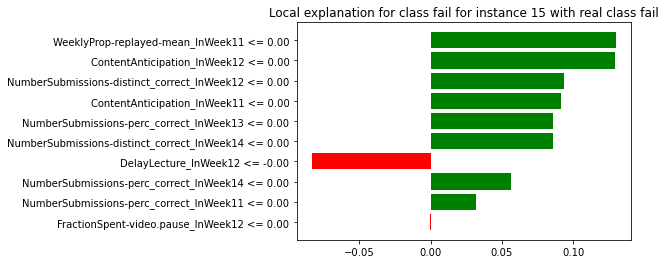

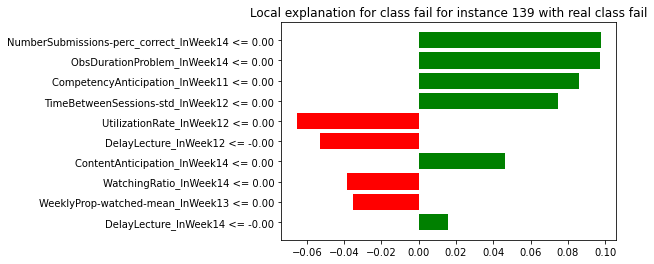

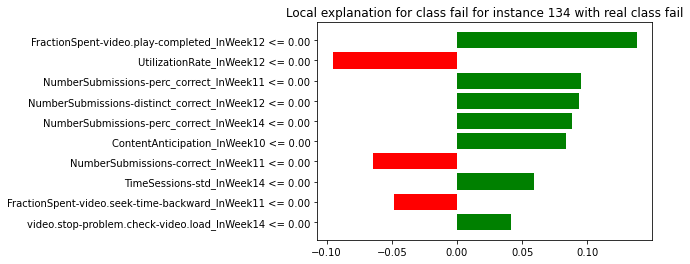

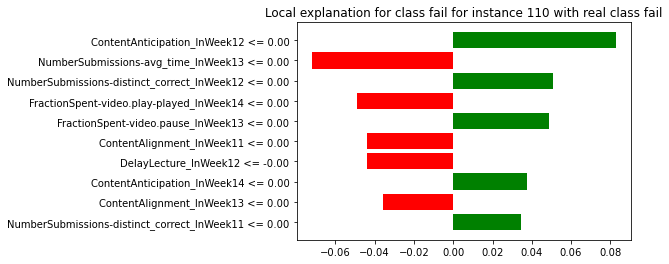

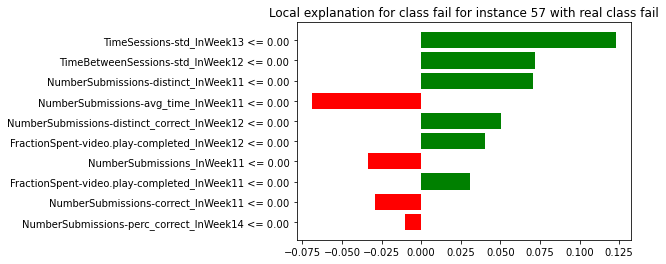

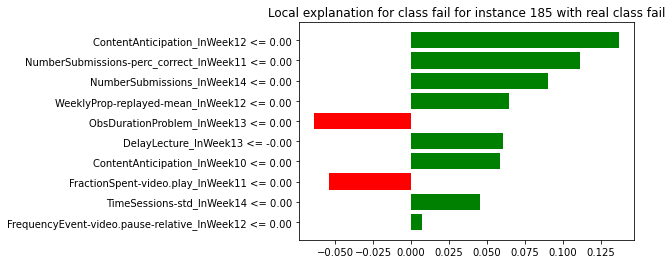

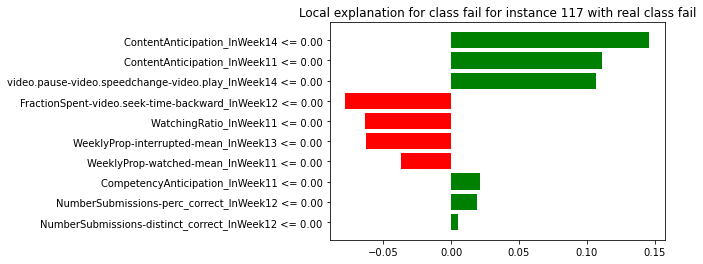

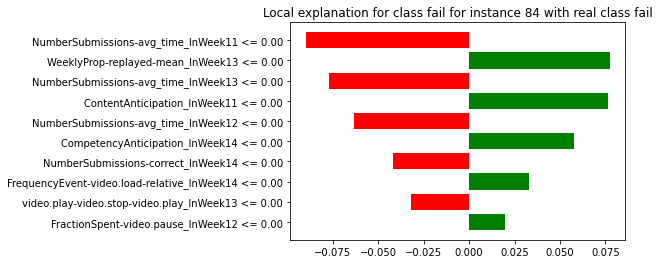

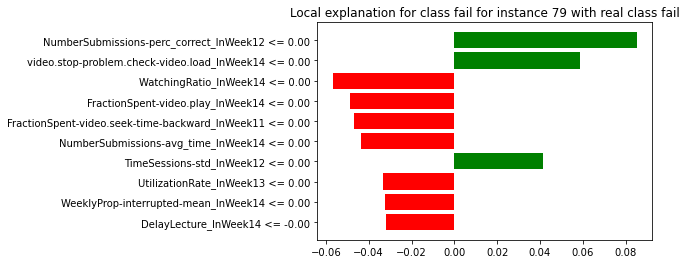

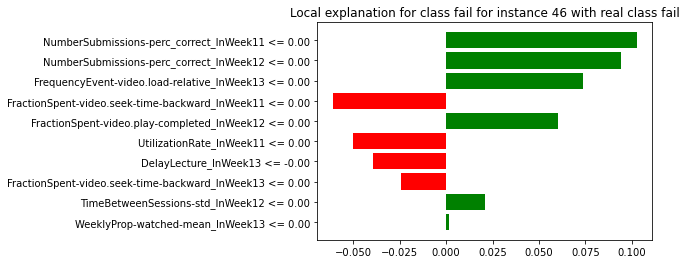

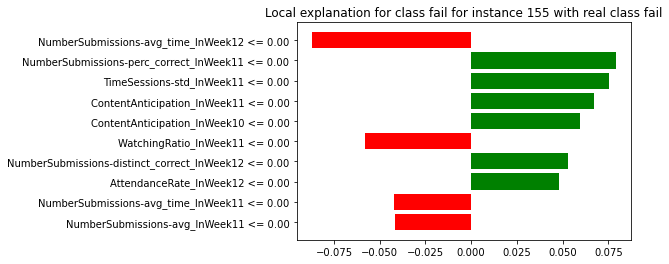

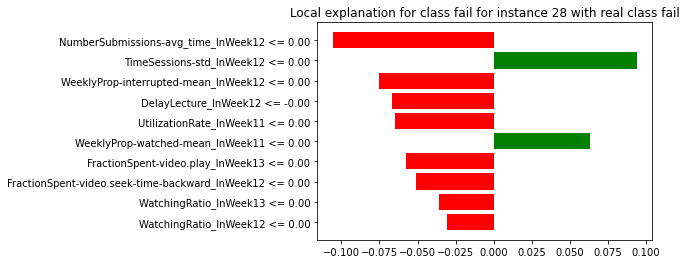

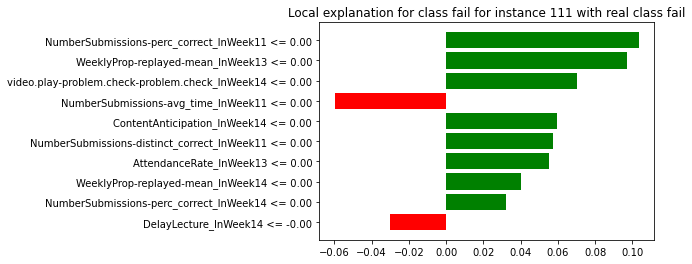

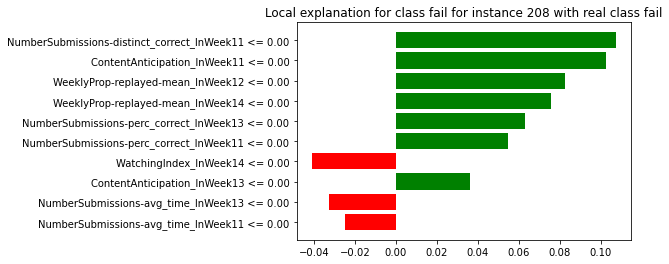

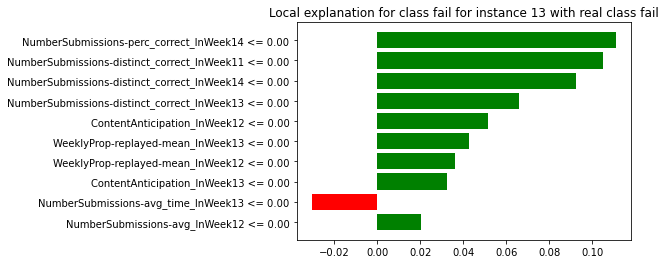

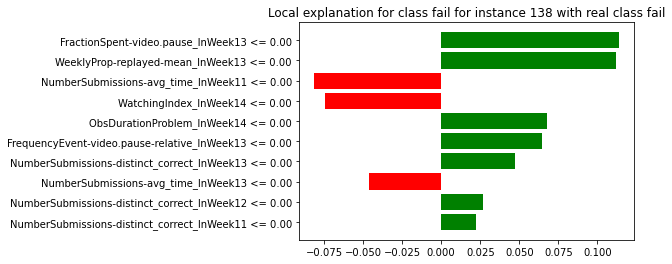

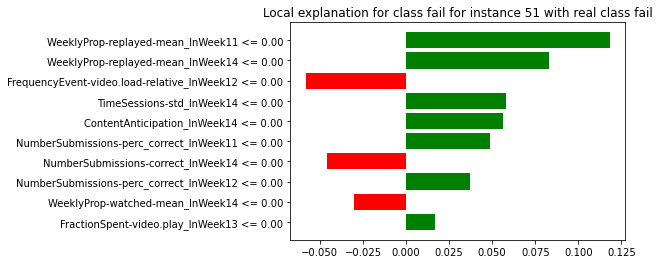

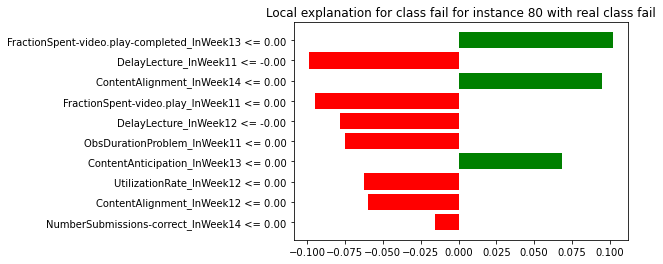

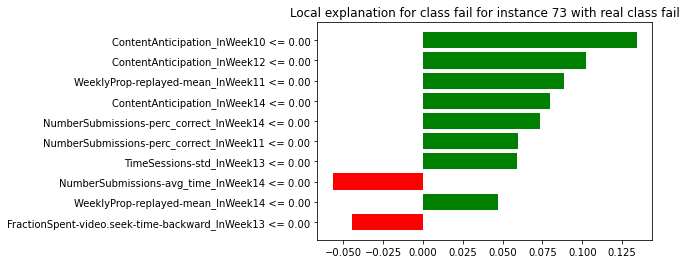

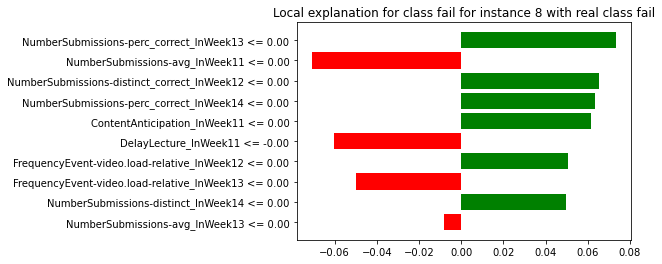

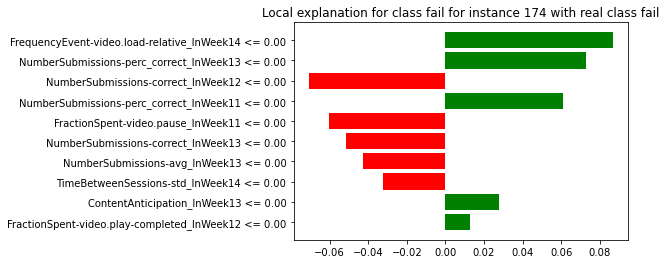

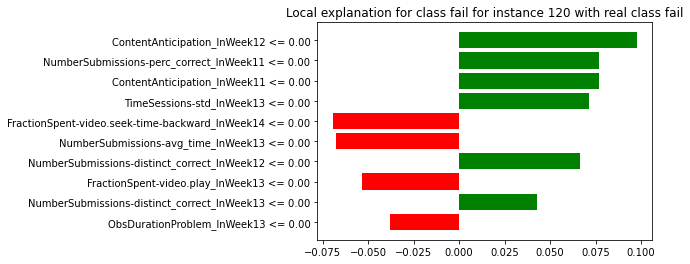

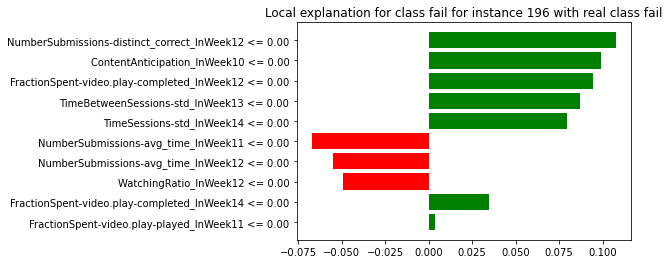

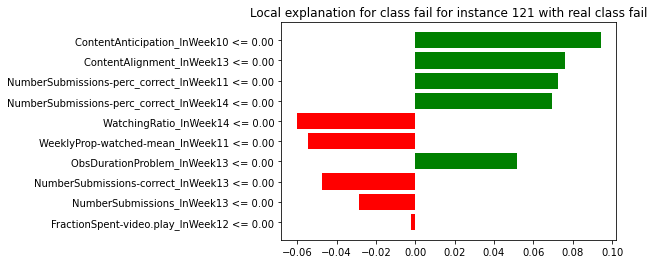

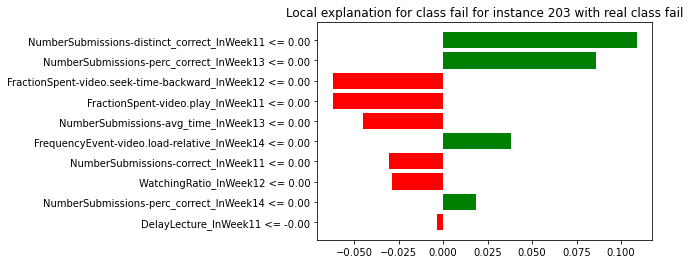

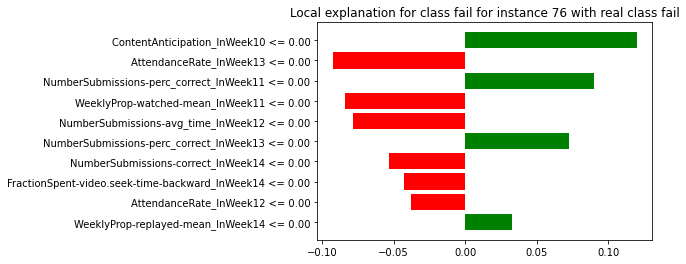

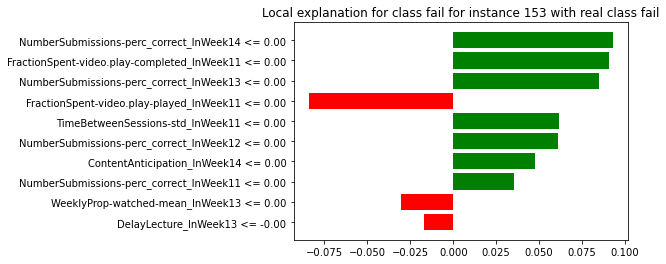

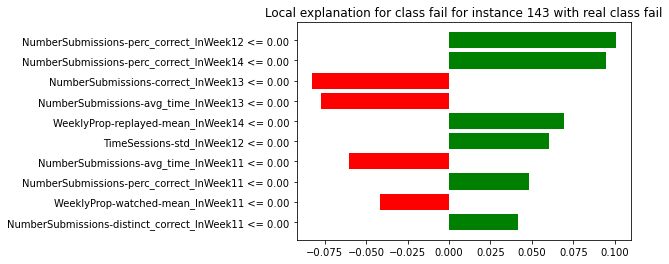

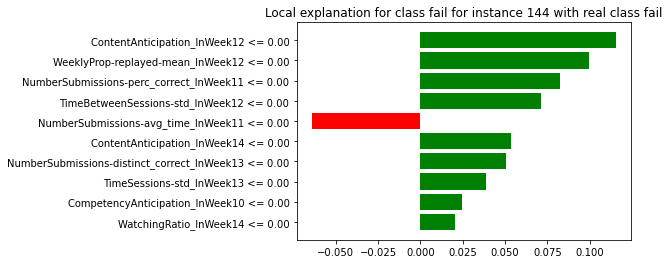

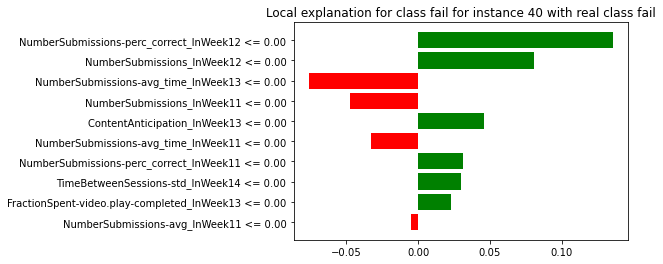

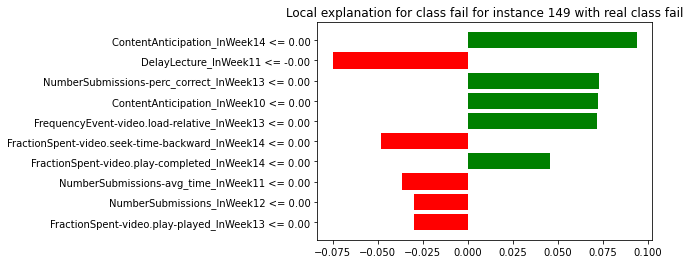

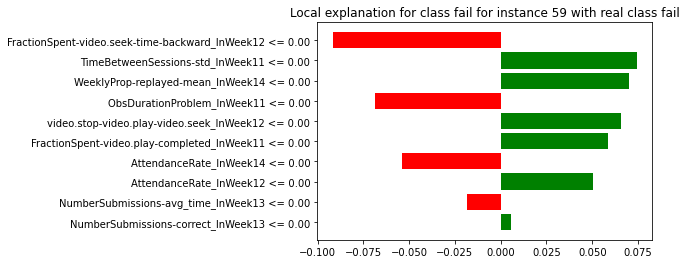

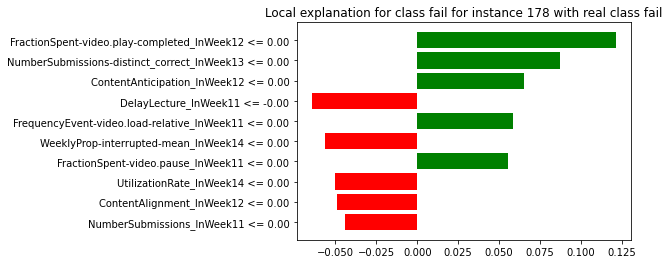

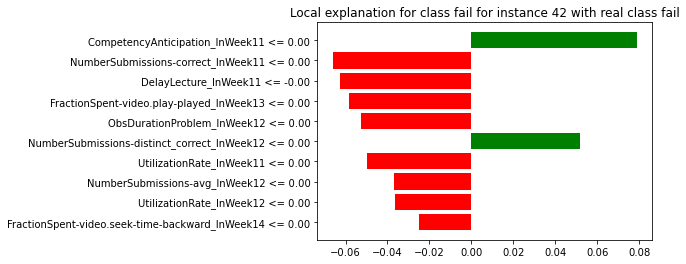

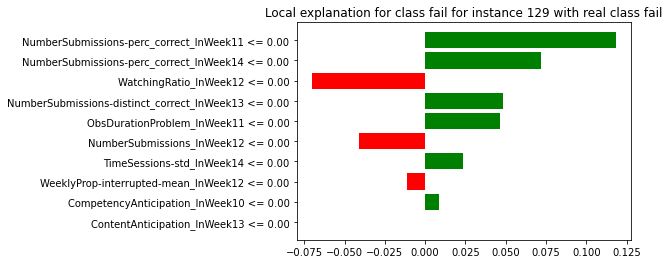

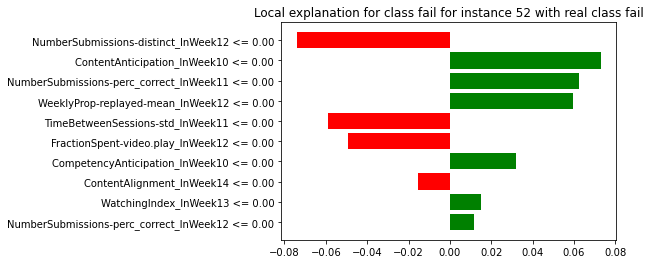

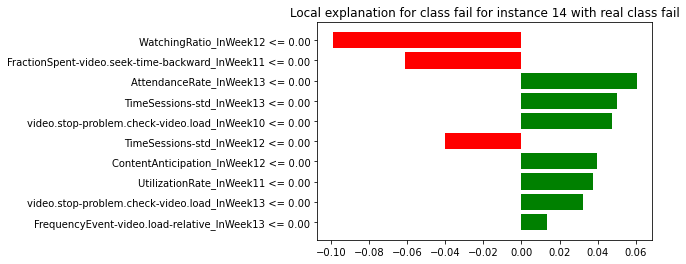

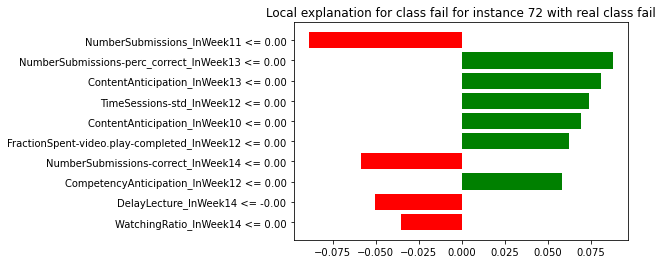

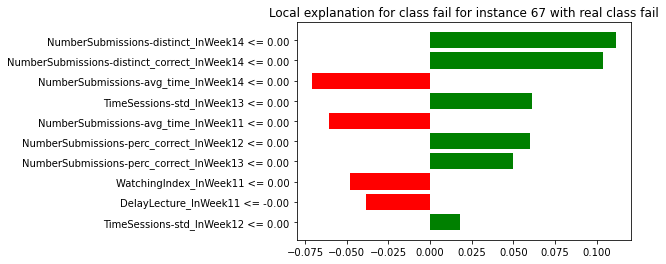

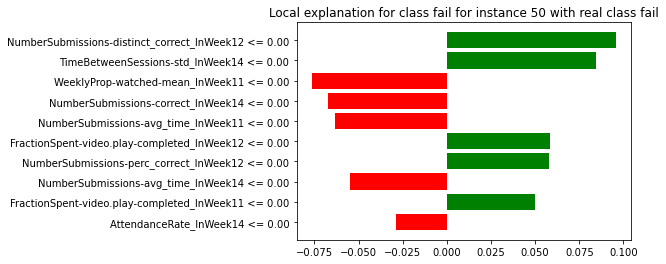

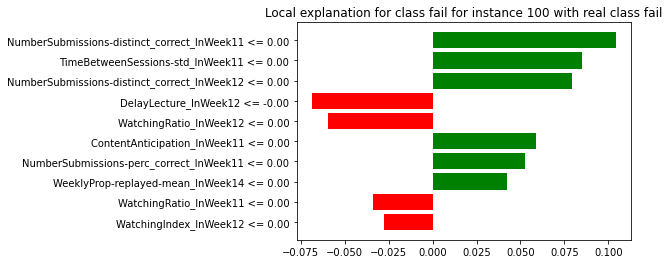

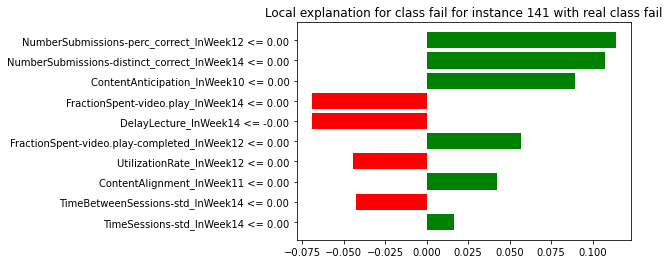

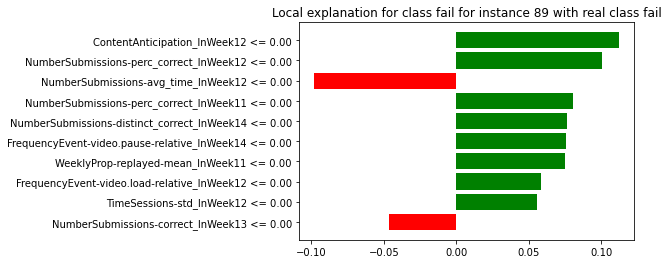

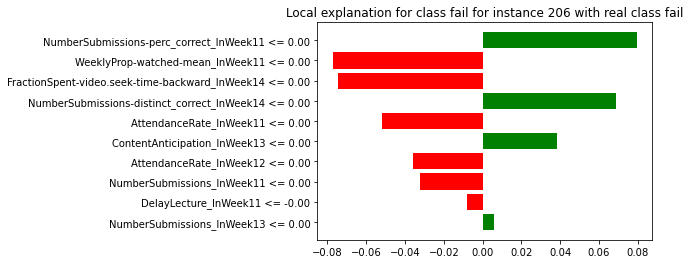

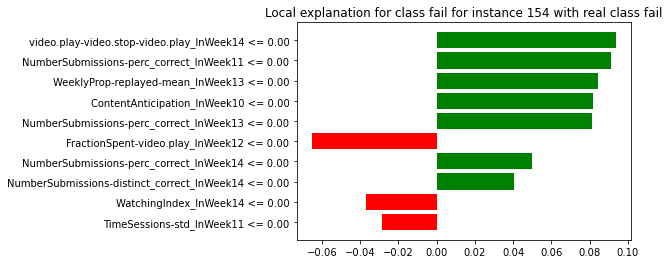

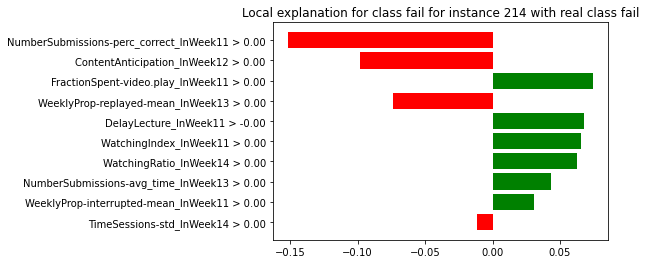

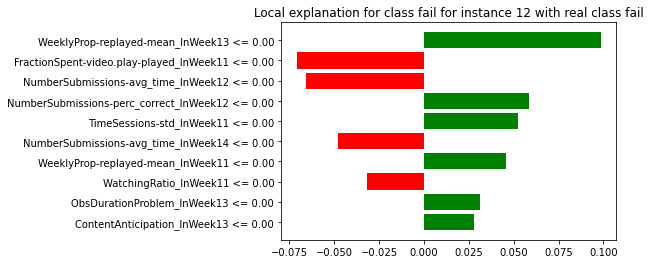

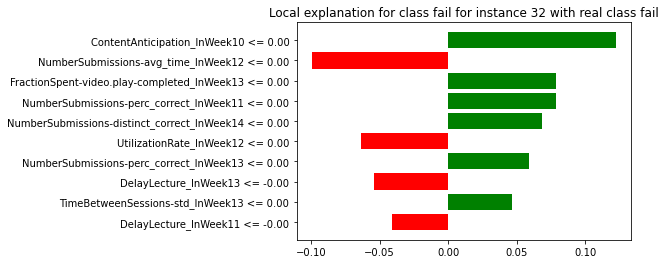

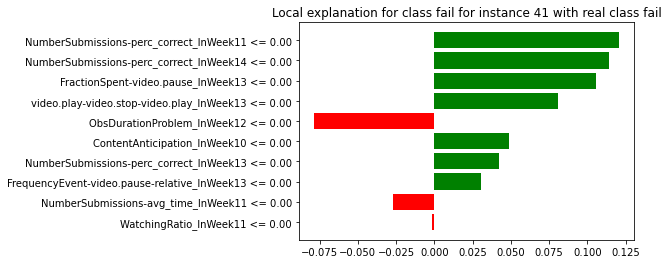

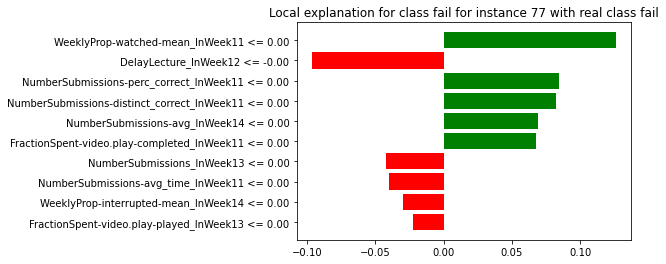

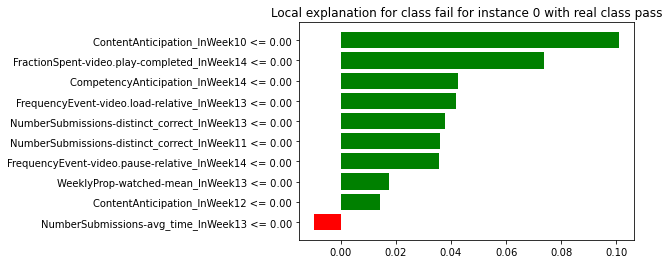

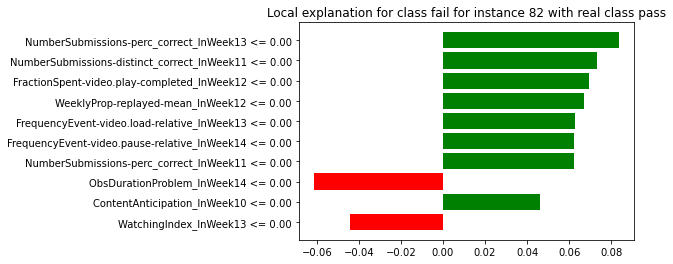

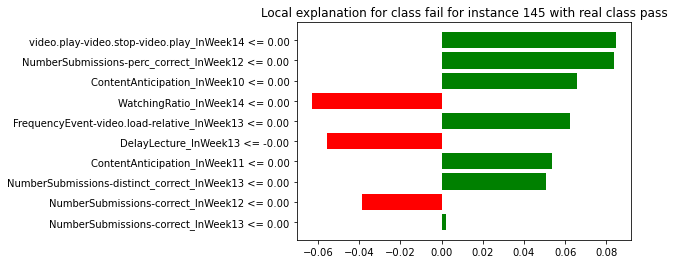

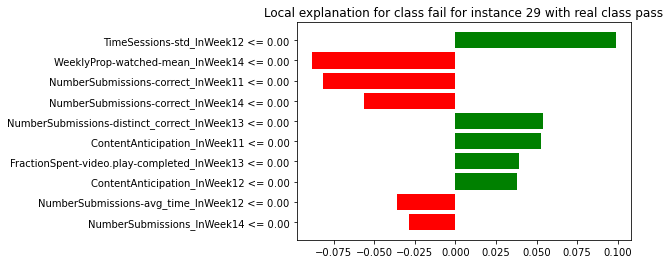

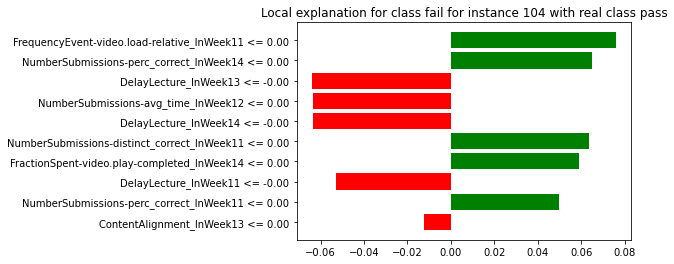

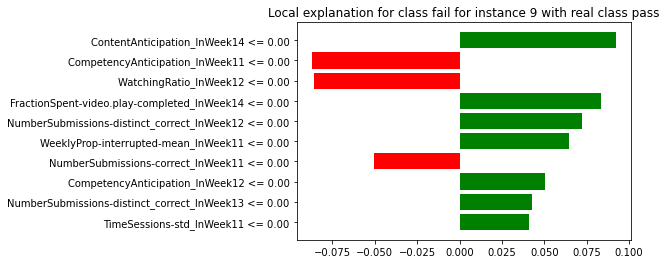

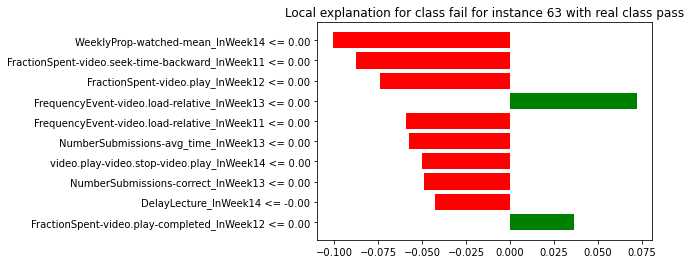

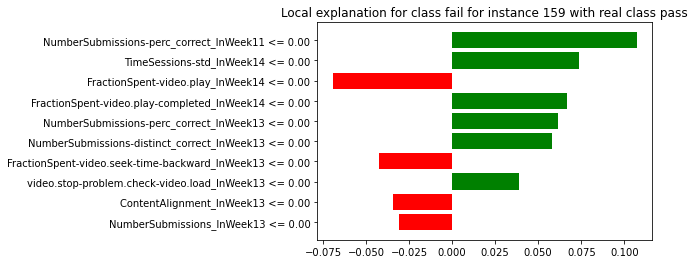

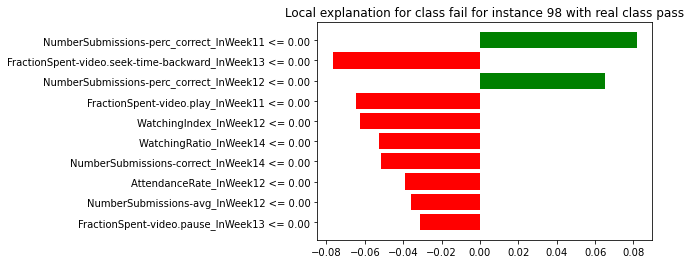

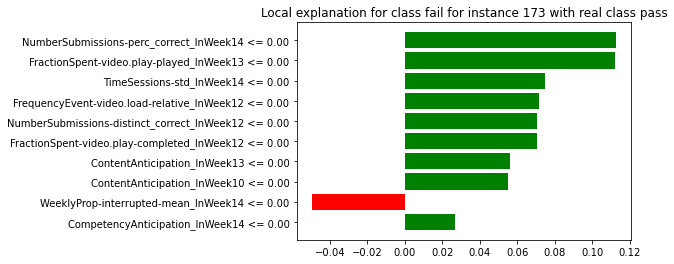

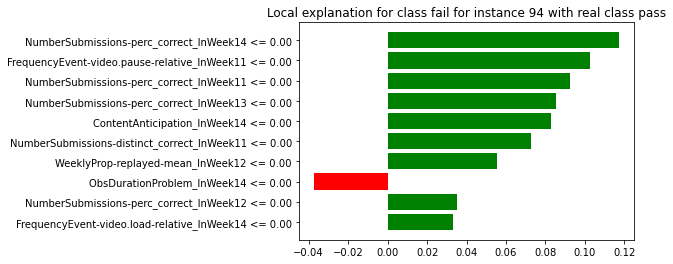

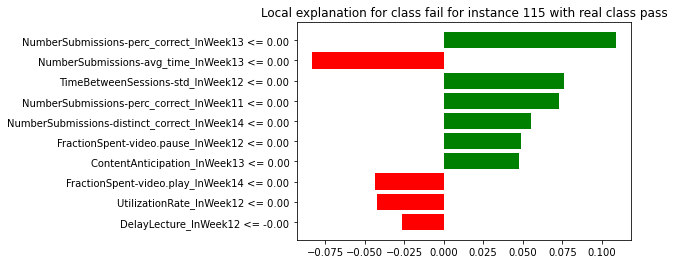

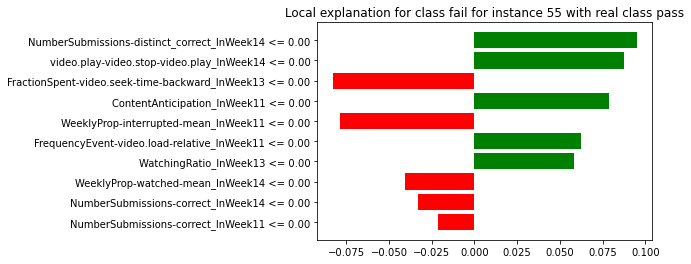

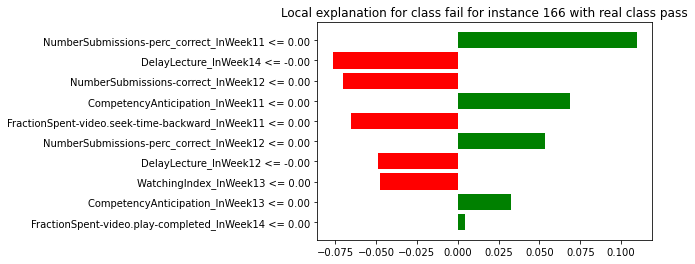

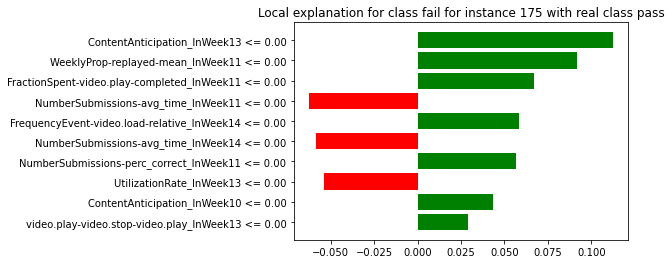

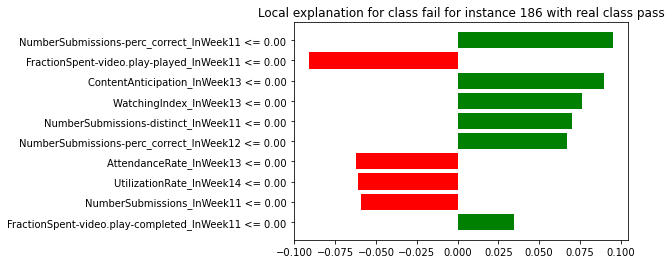

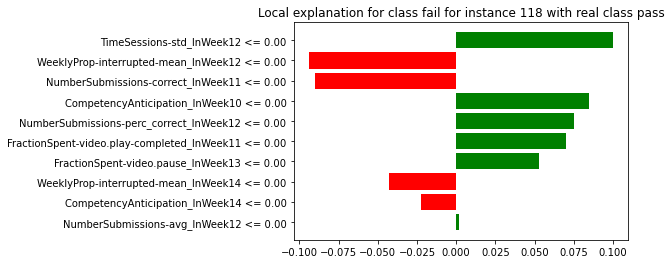

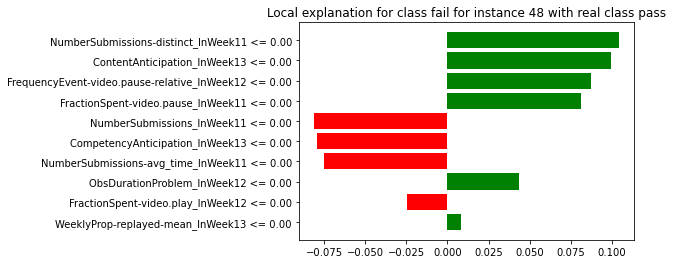

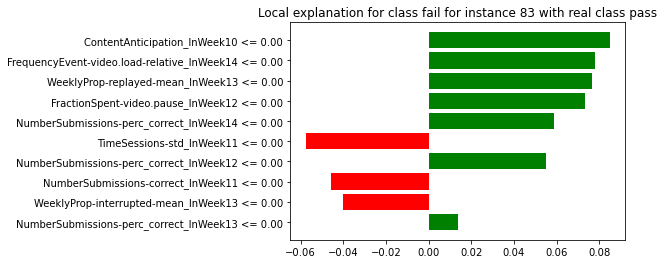

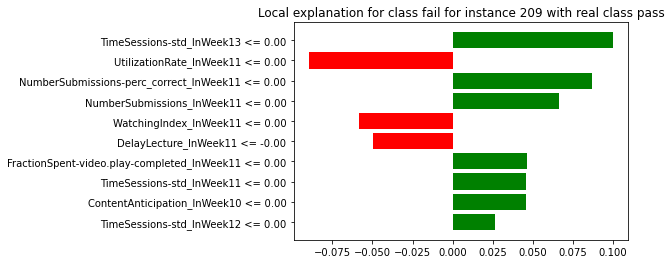

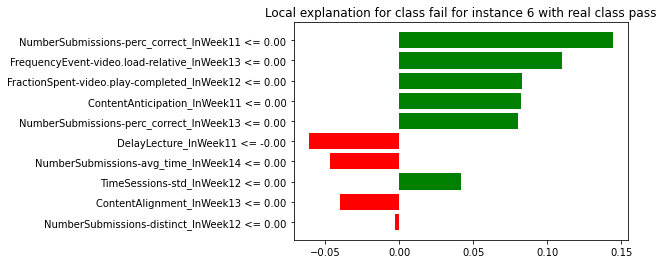

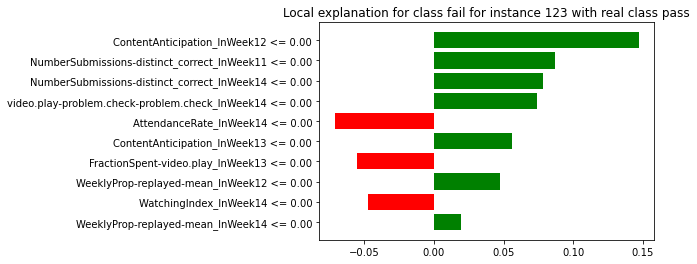

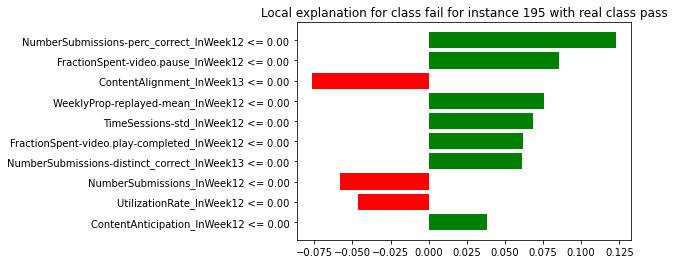

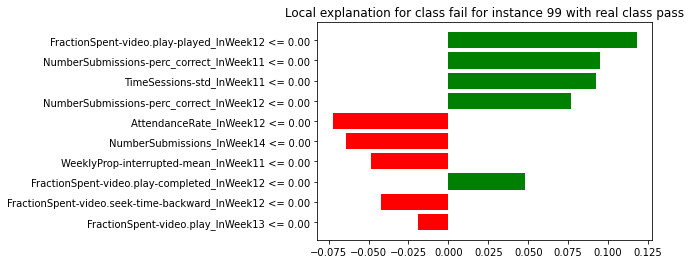

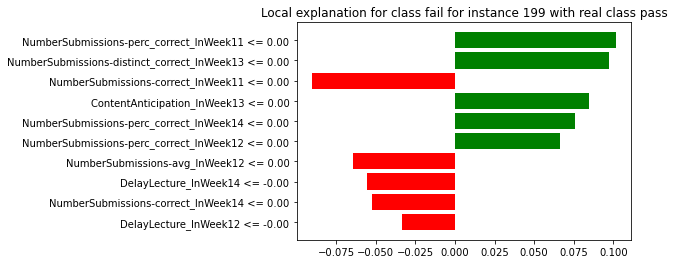

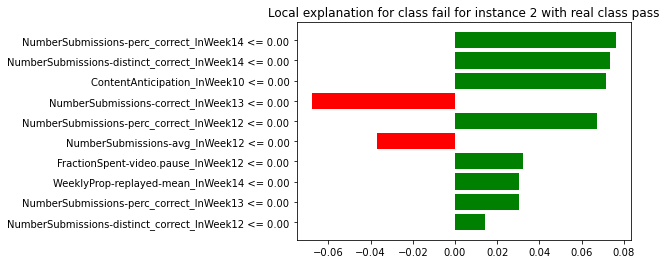

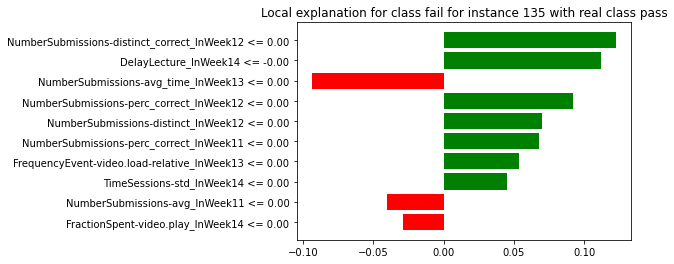

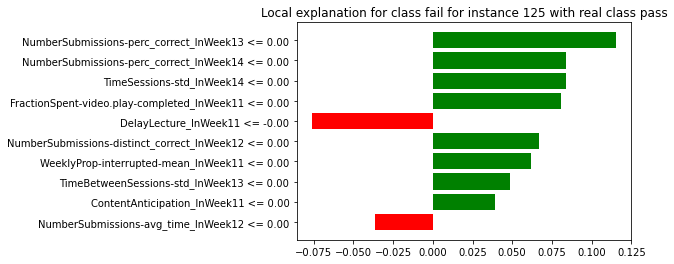

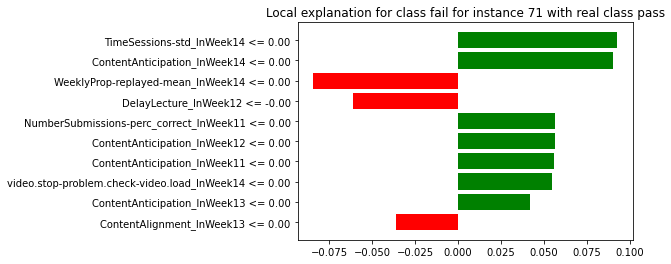

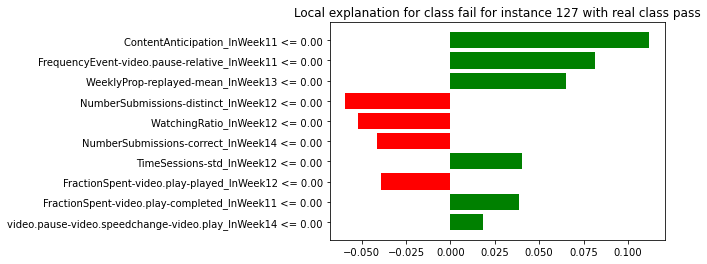

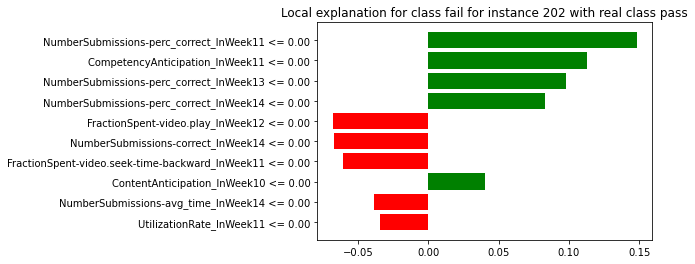

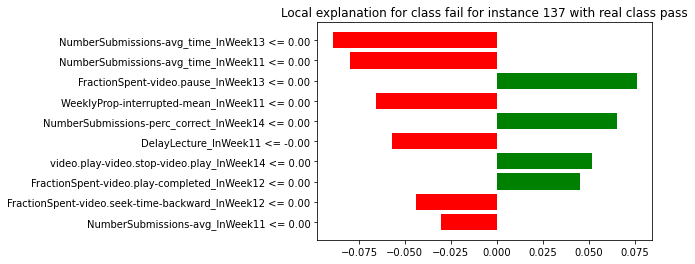

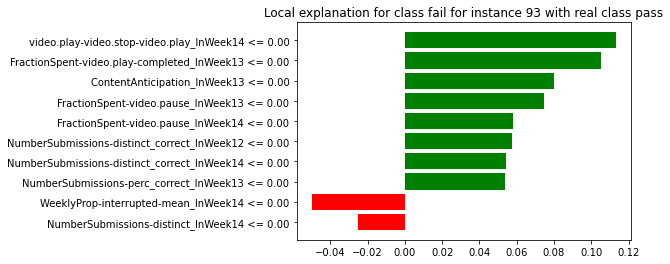

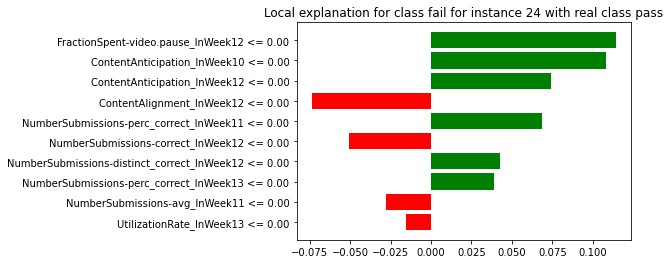

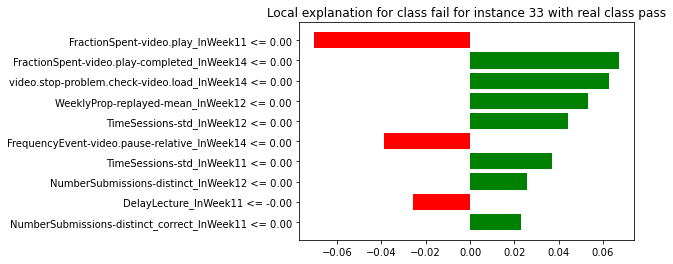

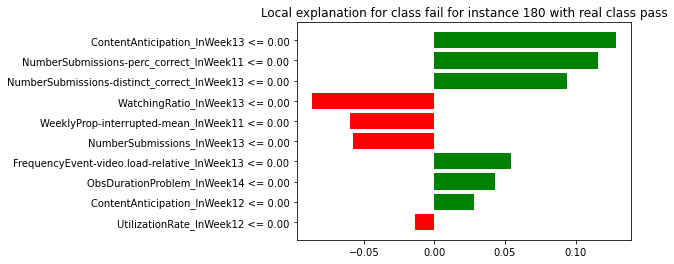

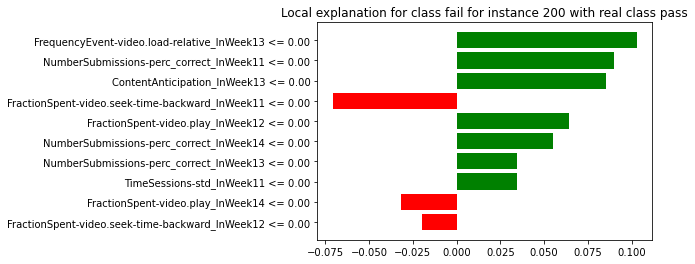

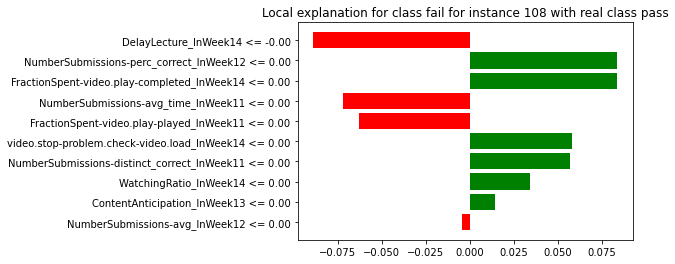

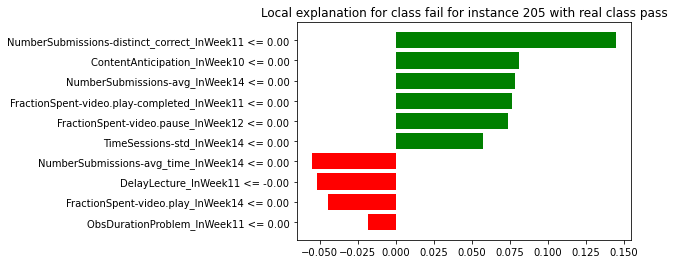

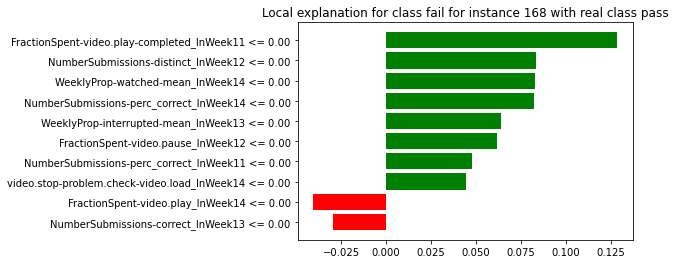

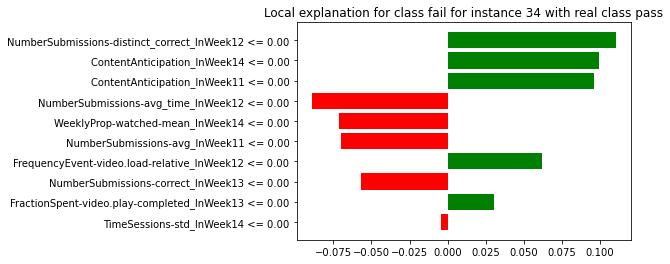

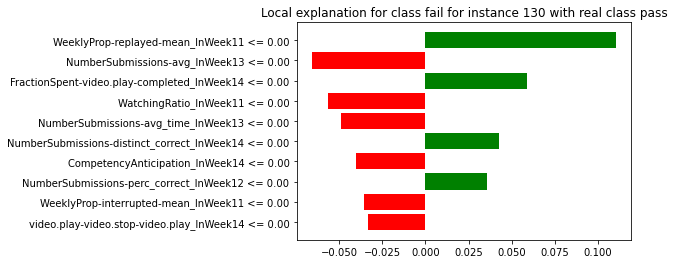

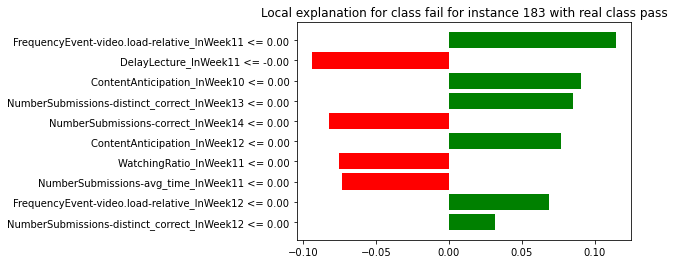

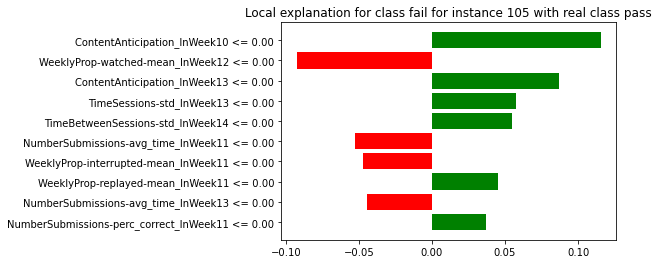

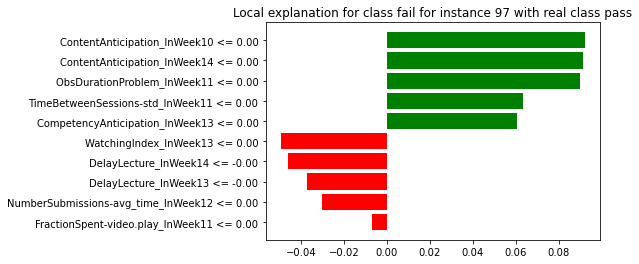

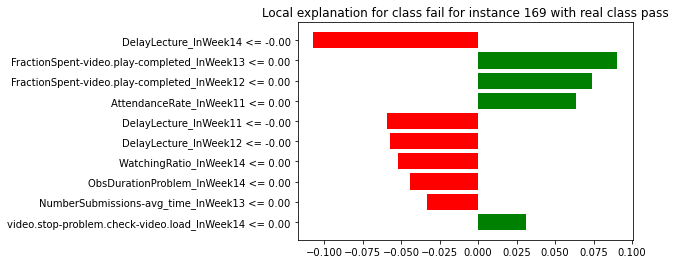

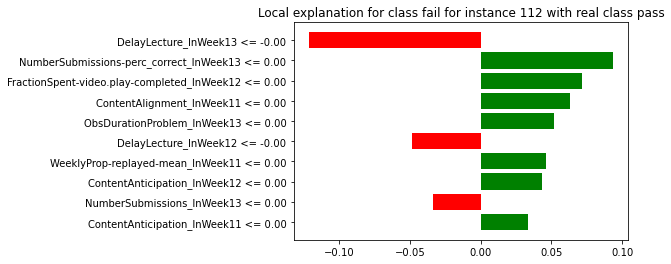

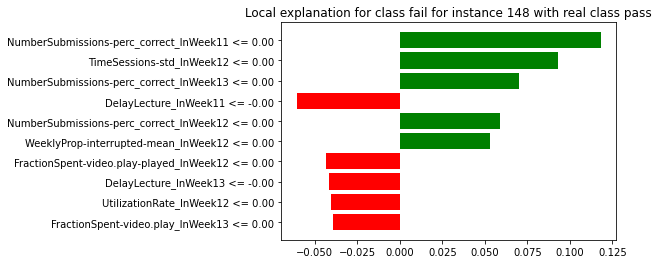

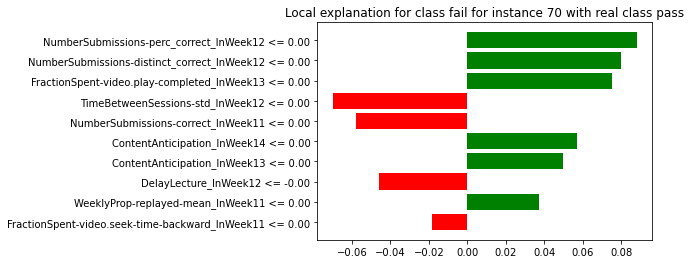

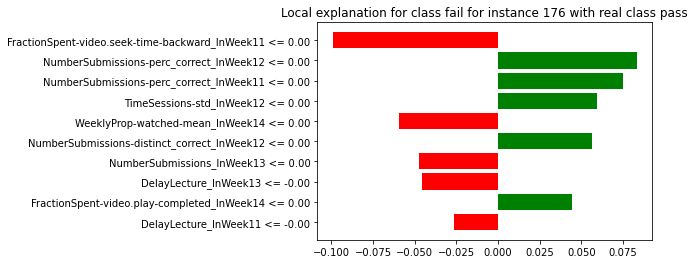

In [33]:
print('pyplot')
pyplot_all(explainers,instances,y,group)


In [34]:
print('df saving')
df,dfl=DataFrame_all(explainers,instances,y,group)

# df.iloc[:,2::] = abs(df.iloc[:,2::])
ai = np.argsort(df.iloc[:,2::].values)
for j,c in enumerate(list(ai[:,:10])):
    df.iloc[j,c+2] = np.arange(1,11)


df saving


/var/folders/16/kn9v95ss6kx75q2kjs2mn9jm0000gn/T/ipykernel_3901/1482758599.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(pd.DataFrame(dfl))


In [35]:
df

exp number real value  WeeklyProp-replayed-mean_InWeek11 <= 0.00  \
0           15       fail                                       10.0   
1          139       fail                                        NaN   
2          134       fail                                        NaN   
3          110       fail                                        NaN   
4           57       fail                                        NaN   
..         ...        ...                                        ...   
95         169       pass                                        NaN   
96         112       pass                                        6.0   
97         148       pass                                        NaN   
98          70       pass                                        5.0   
99         176       pass                                        NaN   

    ContentAnticipation_InWeek12 <= 0.00  \
0                                    9.0   
1                                    NaN   
2                                    NaN   
3                                   10.0   
4                                    NaN   
..                                   ...   
95                                   NaN   
96                                   5.0   
97                                   NaN   
98                                   NaN   
99                                   NaN   

    NumberSubmissions-distinct_correct_InWeek12 <= 0.00  \
0                                                 8.0     
1                                                 NaN     
2                                                 8.0     
3                                                 9.0     
4                                                 7.0     
..                                                ...     
95                                                NaN     
96                                                NaN     
97                                                NaN     
98                                                9.0     
99                                                7.0     

    ContentAnticipation_InWeek11 <= 0.00  \
0                                    7.0   
1                                    NaN   
2                                    NaN   
3                                    NaN   
4                                    NaN   
..                                   ...   
95                                   NaN   
96                                   4.0   
97                                   NaN   
98                                   NaN   
99                                   NaN   

    NumberSubmissions-perc_correct_InWeek13 <= 0.00  \
0                                               6.0   
1                                               NaN   
2                                               NaN   
3                                               NaN   
4                                               NaN   
..                                              ...   
95                                              NaN   
96                                             10.0   
97                                              8.0   
98                                              NaN   
99                                              NaN   

    NumberSubmissions-distinct_correct_InWeek14 <= 0.00  \
0                                                 5.0     
1                                                 NaN     
2                                                 NaN     
3                                                 NaN     
4                                                 NaN     
..                                                ...     
95                                                NaN     
96                                                NaN     
97                                                NaN     
98                                                NaN     
99                                                NaN     

  

In [ ]:
top_features = df.columns
top_features = top_features[2::]
top_features_type = np.array([s[0:s.find('InWeek')].split(' ')[-1] for s in top_features])
top_features_week = np.array([s[s.find('InWeek')+6::].split(' ')[0] for s in top_features])
count = (~(df.iloc[:,2::].isnull())).values.sum(axis=0)
top_features_type_unique = list({ k for k in top_features_type })
count_feature_type = [count[top_features_type==x].sum()/500 for x in top_features_type_unique]
top_features_week_unique = list({ k for k in top_features_week })
count_feature_week = [count[top_features_week==x].sum()/500 for x in top_features_week_unique]


In [ ]:
ind = np.argsort(count_feature_type)[::-1]
fig, ax = pyplot.subplots(figsize=(10, 5),facecolor='white')
g = sns.barplot(x=top_features_type_unique, y=count_feature_type, palette="rocket",ax =ax,order=np.take_along_axis(np.array(top_features_type_unique), ind, axis=0))
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_title( 'important features with respect to their type', fontsize=15)
g.set_xlabel("", fontsize=15)
g.set_ylabel("percent of features", fontsize=12)
if not os.path.exists("./uniform_eq_results_ori/LIME/" + course + "/pyplots/"):
    os.makedirs("./uniform_eq_results_ori/LIME/" + course + "/pyplots/")
pyplot.savefig("./uniform_eq_results_ori/LIME/" + course + "/pyplots/impFeaturesType.png", bbox_inches = 'tight', facecolor=fig.get_facecolor())



In [ ]:
ind = np.argsort(count_feature_week)[::-1]
fig, ax = pyplot.subplots(figsize=(10, 5),facecolor='white')
g = sns.barplot(x=top_features_week_unique, y=count_feature_week, palette="rocket",ax =ax,
                order=np.take_along_axis(np.array(top_features_week_unique), ind, axis=0))
g.set_xticklabels(g.get_xticklabels(),rotation=0)
g.set_title( 'important features with respect to their week', fontsize=15)
g.set_xlabel("", fontsize=15)
g.set_ylabel("percent of features", fontsize=12)

if not os.path.exists("./uniform_eq_results_ori/LIME/" + course + "/pyplots/"):
    os.makedirs("./uniform_eq_results_ori/LIME/" + course + "/pyplots/")
pyplot.savefig("./uniform_eq_results_ori/LIME/" + course + "/pyplots/impFeaturesWeek.png", 
               bbox_inches = 'tight', facecolor=fig.get_facecolor())


In [ ]:
zero_data = np.zeros(shape=(num_weeks,len(top_features_type_unique)))
d = pd.DataFrame(zero_data, columns=top_features_type_unique)
for i,f in enumerate(top_features_type):
    d[f][int(top_features_week[i])-1]+=count[i]
    

In [ ]:
fig, ax = pyplot.subplots(figsize=(10, 10),facecolor='white')
g = sns.heatmap(d.values.T / instances.shape[0], annot=True, fmt=".2f",ax=ax)
l=list(np.arange(1,num_weeks+1))
g.set_xticklabels(['week'+str(i) for i in l],rotation=90)
g.set_yticklabels(top_features_type_unique,rotation=0)

if not os.path.exists("./uniform_eq_results_ori/LIME/" + course + "/pyplots/"):
    os.makedirs("./uniform_eq_results_ori/LIME/" + course + "/pyplots/")
pyplot.savefig("./uniform_eq_results_ori/LIME/" + course + "/pyplots/heatmap.png", bbox_inches = 'tight', facecolor=fig.get_facecolor())



In [ ]:
if not os.path.exists("./uniform_eq_results_ori/LIME/"+course+"/dataframes/"):
    os.makedirs("./uniform_eq_results_ori/LIME/"+course+"/dataframes/")

df.to_csv(r'./uniform_eq_results_ori/LIME/'+course+'/dataframes/all_important_features.csv', index = False, header = True)
d.to_csv(r'./uniform_eq_results_ori/LIME/'+course+'/dataframes/df_for_heatmap.csv', index = False, header = True)

